In [182]:
import numpy as np
import time
from util import generate_sparse_least_squares
from optim import primal_gradient as pg, dual_gradient as dg, nesterov_accelerated_gradient as nag

Implementation of methods

In [183]:
# primal
def primal_gradient_method_with_history(A, b, x0, tol, max_iter=10000):
    """
    Implement the primal gradient method to solve Ax = b, tracking both gap history and loss history.
    
    Args:
        A (np.ndarray): Coefficient matrix.
        b (np.ndarray): Right-hand side vector.
        x0 (np.ndarray): Initial guess for the solution.
        tol (float): Tolerance for stopping criterion based on relative gap.
        max_iter (int): Maximum number of iterations.
    
    Returns:
        Tuple containing:
        - np.ndarray: The solution vector x.
        - int: Total number of iterations performed.
        - float: Final relative gap.
        - list: History of the relative gap during iterations.
        - list: History of the loss (norm of residual squared) during iterations.
    """
    m, n = A.shape
    x = x0
    r = np.dot(A, x) - b  # initial residual
    initial_loss = np.linalg.norm(r)**2
    gap_history = []
    loss_history = [initial_loss]
    cpu_time_history = []

    for k in range(max_iter):
        start_time = time.process_time()
        gradient = 2 * np.dot(A.T, (np.dot(A, x) - b))
        step_size = 0.1 / np.linalg.norm(gradient)  # simple step size rule
        x -= step_size * gradient
        r = np.dot(A, x) - b
        current_loss = np.linalg.norm(r)**2
        
        relative_gap = current_loss / initial_loss
        loss_history.append(current_loss)
        gap_history.append(relative_gap)
        end_time = time.process_time()
        cpu_time_history.append(end_time - start_time)
        
        if relative_gap < tol:
            break

    return x, k, relative_gap, gap_history, loss_history, cpu_time_history

# print("Solution found after {} iterations with final relative gap: {:.4f}".format(iterations, final_gap))
# print("Gap history:", gap_history_primal)
# print("Loss history:", loss_history)


In [184]:
# dual
def dual_gradient_method_with_nesterov_and_history(A, b, v0, L0, gamma_d, max_iter=10000, tol=1e-6):
    """
    Dual Gradient Method with Nesterov acceleration for solving Ax = b using least squares,
    including gap history and loss history.
    """
    m, n = A.shape
    v = v0
    v_prev = v0
    L = L0
    gap_history = []
    loss_history = []
    cpu_time_history = []
    initial_residual = np.dot(A, v) - b
    initial_loss = np.linalg.norm(initial_residual)**2 / 2

    for k in range(max_iter):
        start_time = time.process_time()
        # Nesterov acceleration step
        if k > 0:
            y = v + (k - 1) / (k + 2) * (v - v_prev)
        else:
            y = v

        grad_f = 2 * np.dot(A.T, (np.dot(A, y) - b))  # Gradient of the least squares loss

        Mk = np.linalg.norm(grad_f, 2)                # Computing Mk
        if Mk == 0:
            Mk = 1e-16  # Prevent division by zero

        v_prev = v
        v -= gamma_d * grad_f / Mk
        
        end_time = time.process_time()

        current_residual = np.dot(A, v) - b
        current_loss = np.linalg.norm(current_residual)**2 / 2
        current_gap = np.linalg.norm(current_residual)**2 / np.linalg.norm(initial_residual)**2

        gap_history.append(current_gap)
        loss_history.append(current_loss)
        cpu_time_history.append(end_time - start_time)

        # Check for convergence based on the relative gap
        if current_gap < tol:
            break

    return v, k, current_gap, gap_history, loss_history, cpu_time_history

# Parameters
# m, n = 1000, 4000  # dimensions
# rho = 0.5          # sparsity factor
# tol = 1e-9         # tolerance for relative gap reduction

# # Generate the problem
# A, b, x_star = generate_sparse_least_squares(m, n, rho)

# Initial guess and parameters for the method



In [185]:
# nesterov accelerated gradient
from optim import nesterov_accelerated_gradient as nag

### Tests

In [186]:
def find_magnitude_indices(gap_history, func=np.log10):
    magnitudes = np.floor(func(gap_history))
    unique_magnitudes = []
    indices = []
    magnitudes_saved = []
    for i, magnitude in enumerate(magnitudes):
        if magnitude not in unique_magnitudes:
            unique_magnitudes.append(magnitude)
            magnitudes_saved.append(magnitude)
            indices.append(i+1)
    indices = np.array(indices)
    return indices, magnitudes_saved

In [187]:
# Parameters
m, n = 1000, 4000  # dimensions
rho = 0.1        # sparsity factor
tol = 1e-9         # tolerance for relative gap reduction

# Generate the problem
A, b, x_star = generate_sparse_least_squares(m, n, rho)

In [188]:
# primal
x0 = np.zeros(n)
solution_primal, iterations_primal, final_gap_primal, gap_history_primal, loss_history_primal, cpu_history_primal = primal_gradient_method_with_history(A, b, x0, tol)
indices_primal, magnitudes_primal = find_magnitude_indices(gap_history_primal)
cpu_history_primal = np.array(cpu_history_primal).cumsum()[indices_primal]

In [189]:
# dual
v0 = np.zeros(n)
L0 = 2
gamma_d = 0.1
solution_dual, iterations_dual, final_gap_dual, gap_history_dual, loss_history_dual, cpu_history_dual = dual_gradient_method_with_nesterov_and_history(A, b, v0, L0, gamma_d, tol=tol)
indices_dual, magnitudes_dual = find_magnitude_indices(gap_history_dual)
cpu_history_dual= np.array(cpu_history_dual).cumsum()[indices_dual]


In [200]:
# nesterov
beta_nesterov, loss_history_nesterov, gap_history_nesterov, cpu_history_nesterov = nag(A, b, tol=tol, lambda_=0.1)
indices_nesterov, magnitudes_nesterov = find_magnitude_indices(gap_history_nesterov)
cpu_history_plot_nesterov =  np.array(cpu_history_nesterov).cumsum()[indices_nesterov]

In [201]:
len(loss_history_primal), len(loss_history_dual), len(loss_history_nesterov)

(10001, 10000, 1000)

In [209]:
# plot gap
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(indices_primal, gap_history_primal[indices_primal], label="Primal Gradient")
plt.plot(indices_dual, gap_history_dual[indices_dual], label="Dual Gradient")
plt.plot(indices_nesterov, gap_history_nesterov[indices_nesterov], label="Nesterov Accelerated Gradient")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Relative Gap")
plt.legend()
plt.title("Relative Gap vs. Iteration")
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1000x600 with 0 Axes>

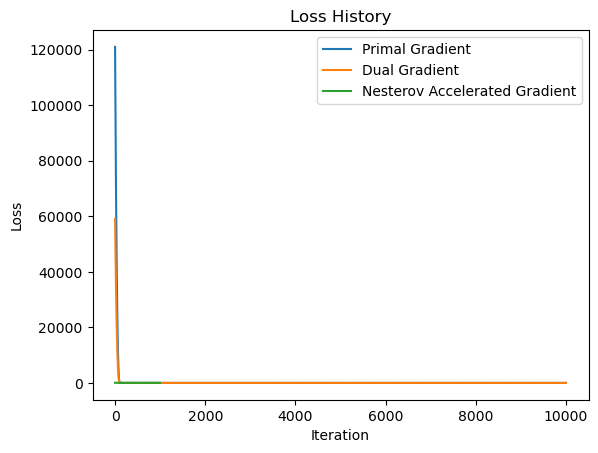

In [202]:
# plot loss history
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_history_primal, label='Primal Gradient')
plt.plot(loss_history_dual, label='Dual Gradient')
plt.plot(loss_history_nesterov, label='Nesterov Accelerated Gradient')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.show()

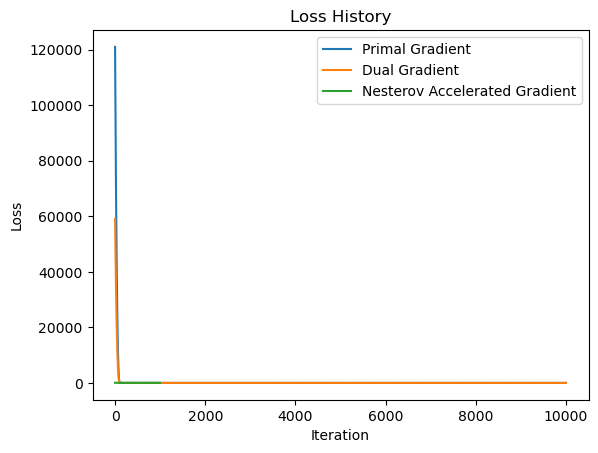

In [203]:
# plot loss_history over iterations
plt.figure()
plt.plot(loss_history_primal, label='Primal Gradient')
plt.plot(loss_history_dual, label='Dual Gradient')
plt.plot(loss_history_nesterov, label='Nesterov Accelerated Gradient')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.show()

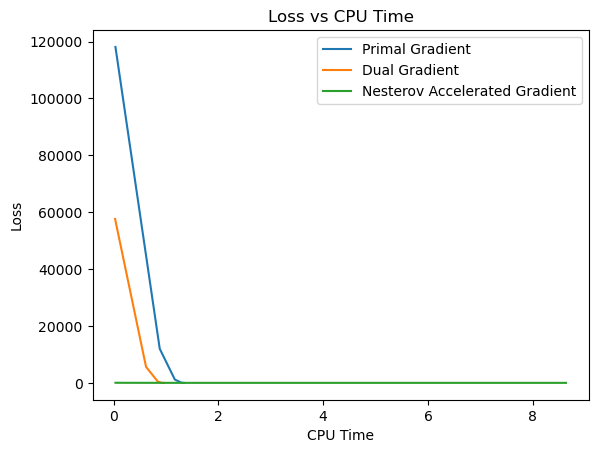

In [204]:
# plot the cpu time 
plt.figure()
plt.plot(cpu_history_primal, np.array(loss_history_primal)[indices_primal], label='Primal Gradient')
plt.plot(cpu_history_dual, np.array(loss_history_dual)[indices_dual], label='Dual Gradient')
plt.plot(cpu_history_plot_nesterov, np.array(loss_history_nesterov)[indices_nesterov], label='Nesterov Accelerated Gradient')
plt.xlabel('CPU Time')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs CPU Time')
plt.show()

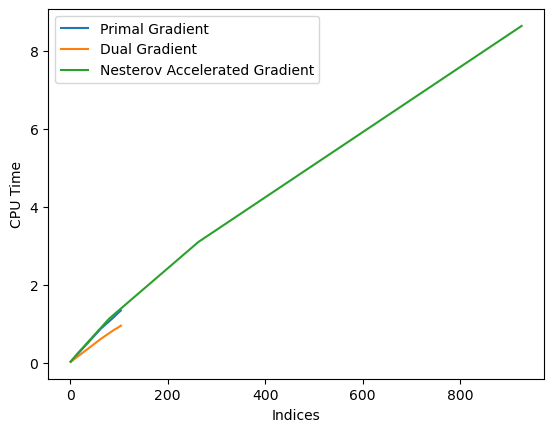

In [205]:
# plot the cpu time vs. indices for each method
import matplotlib.pyplot as plt
plt.plot(indices_primal, cpu_history_primal, label='Primal Gradient')
plt.plot(indices_dual, cpu_history_dual, label='Dual Gradient')
plt.plot(indices_nesterov, cpu_history_plot_nesterov, label='Nesterov Accelerated Gradient')
plt.xlabel('Indices')
plt.ylabel('CPU Time')
plt.legend()
plt.show()

In [36]:
import numpy as np

def generate_sparse_least_squares(m, n, rho):
    """ Generate a sparse least squares problem """
    A = np.random.uniform(-1, 1, (m, n))
    x_star = np.zeros(n)
    non_zero_indices = np.random.choice(n, int(n * rho), replace=False)
    x_star[non_zero_indices] = np.random.normal(0, 1, int(n * rho))
    noise = np.random.normal(0, 0.1, m)
    b = np.dot(A, x_star) + noise
    return A, b, x_star

def dual_gradient_method(A, b, v0, L0, gamma_d, max_iter=10000, tol=1e-6):
    """
    Dual Gradient Method adapted for solving Ax = b using least squares
    """
    m, n = A.shape
    v = v0
    L = L0
    k = 0
    initial_residual = np.dot(A, v) - b
    initial_gap = np.linalg.norm(initial_residual)**2
    
    while k < max_iter:
        grad_f = 2 * np.dot(A.T, (np.dot(A, v) - b))  # Gradient of the least squares loss
        Mk = np.linalg.norm(grad_f, 2)                # Computing Mk
        
        if Mk == 0:
            Mk = 1e-16  # Prevent division by zero
        
        # Update step
        v -= grad_f / Mk
        
        # Calculate current residual and gap
        current_residual = np.dot(A, v) - b
        current_gap = np.linalg.norm(current_residual)**2
        relative_gap = current_gap / initial_gap
        
        # Check for convergence
        if relative_gap < tol:
            break
        
        k += 1

    return v, k, relative_gap

# Parameters
# m, n = 1000, 4000  # dimensions
# rho = 0.5          # sparsity factor
# tol = 1e-9         # tolerance for relative gap reduction

# # Generate the problem
# A, b, x_star = generate_sparse_least_squares(m, n, rho)

# Initial guess
v0 = np.zeros(n)

# Solve using Dual Gradient Method
solution, iterations, final_gap = dual_gradient_method(A, b, v0, 2, 2, tol=tol)

print("Solution found after {} iterations with final relative gap: {:.4f}".format(iterations, final_gap))


Solution found after 10000 iterations with final relative gap: 0.0013


In [50]:
# Parameters
m, n = 1000, 4000  # dimensions
rho = 0.03         # sparsity factor
tol = 1e-9         # tolerance for relative gap reduction

# Generate the problem
A, b, x_star = generate_sparse_least_squares(m, n, rho)

# Initial guess
x0 = np.zeros(n)

# Solve using primal gradient method with history tracking
solution, iterations, final_gap, gap_history_primal, loss_history = primal_gradient_method_with_history(A, b, x0, tol)

# Initial guess
v0 = np.zeros(n)
L0 = 2
gamma_d = 0.1

# Solve using Dual Gradient Method with enhancements
solution, iterations, final_gap, gap_history_dual, loss_history = dual_gradient_method_with_nesterov_and_history(A, b, v0, L0, gamma_d, tol=tol)

print(find_magnitude_indices(gap_history_primal, func=np.log2))
print(find_magnitude_indices(gap_history_dual, func=np.log2))

[(-1.0, 1), (-2.0, 15), (-3.0, 26), (-4.0, 34), (-5.0, 40), (-6.0, 45), (-7.0, 48), (-8.0, 51), (-9.0, 53), (-10.0, 55), (-11.0, 56), (-13.0, 57), (-18.0, 58), (-14.0, 59), (-15.0, 60), (-12.0, 85)]
[(-1.0, 1), (-2.0, 15), (-3.0, 26), (-4.0, 34), (-5.0, 40), (-6.0, 45), (-7.0, 48), (-8.0, 51), (-9.0, 53), (-10.0, 55), (-11.0, 56), (-13.0, 57), (-18.0, 58), (-14.0, 59), (-15.0, 60), (-12.0, 85)]


In [45]:
# check if two lists are equal
def check_equality(list1, list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            return False
    return True

In [49]:
print(find_magnitude_indices(gap_history_primal, func=np.log2))
print("*")
find_magnitude_indices(gap_history_dual, func=np.log2)

[(-1.0, 1), (-2.0, 19), (-3.0, 33), (-4.0, 44), (-5.0, 52), (-6.0, 58), (-7.0, 63), (-8.0, 66), (-9.0, 69), (-10.0, 71), (-11.0, 72), (-12.0, 73), (-13.0, 74), (-16.0, 75), (-15.0, 78), (-14.0, 80)]
*


[(-1.0, 1),
 (-2.0, 19),
 (-3.0, 33),
 (-4.0, 44),
 (-5.0, 52),
 (-6.0, 58),
 (-7.0, 63),
 (-8.0, 66),
 (-9.0, 69),
 (-10.0, 71),
 (-11.0, 72),
 (-12.0, 73),
 (-13.0, 74),
 (-16.0, 75),
 (-15.0, 78),
 (-14.0, 80)]

In [177]:
final_gap

1.4346651108469044e-05

In [182]:
len(find_magnitude_indices(gap_history, func=np.log2))

22